In [3]:
import cdsapi
import numpy as np
import os 
c = cdsapi.Client()

area = [46.4, -122.4, 46, -122]
years = [str(ii) for ii in 1993 + np.arange(31)]
days = [str(ii) for ii in np.arange(31) + 1]
months = [str(ii) for ii in np.arange(12) + 1]

outfolder = '../climate data/larger_area'

# Precipitation

In [5]:
for year in years:
    if os.path.exists(os.path.join(outfolder, f'precip_{year}.grib')):
        continue
    c.retrieve(
        'reanalysis-era5-land',
        {
            'variable': 'total_precipitation',
            'year': year,
            'area': area,
            'time': '10:00',
            'day': days,
            'month': months,
            'format': 'grib',
        },
        os.path.join(outfolder, f'precip_{year}.grib'))



## Snowfall

In [6]:
for year in years:
    if os.path.exists(os.path.join(outfolder, f'snowfall_{year}.grib')):
        continue
    c.retrieve(
        'reanalysis-era5-land',
        {
            'variable': 'snowfall',
            'year': year,
            'area': area,
            'time': '10:00',
            'day': days,
            'month': months,
            'format': 'grib',
        },
        os.path.join(outfolder, f'snowfall_{year}.grib'))



## Snowmelt

In [7]:
for year in years:
    if os.path.exists(os.path.join(outfolder, f'snowmelt{year}.grib')):
        continue
    c.retrieve(
        'reanalysis-era5-land',
        {
            'variable': 'snowmelt',
            'year': year,
            'area': area,
            'time': '10:00',
            'day': days,
            'month': months,
            'format': 'grib',
        },
        os.path.join(outfolder, f'snowmelt{year}.grib'))



# Recombine & downsample

In [8]:
from datetime import date, datetime, timedelta
import os
from typing import Tuple
import locale
from copy import deepcopy

import matplotlib
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
import numpy as np
from obspy.core.inventory.inventory import read_inventory
from obspy.core.inventory.station import Station
import pygrib
import pandas as pd

def plot_clim_at_stat(
    data: np.ndarray, latv:np.ndarray, lonv:np.ndarray, stat: Station,
    dt: timedelta, dt2: timedelta,
    startdate: datetime, ylabel: str, title: str,
        tlim: Tuple[datetime, datetime], return_data=False):
    """
    Plots the dataset from the provided *grib* for the coordinates of the
    station. The dataset is assumed to span a time window.

    :param gribfile: *.grib* file containing climate data
    :type gribfile: str
    :param stat: Seismic Station
    :type stat: Station
    :param dt: Sampling interval
    :type dt: timedelta
    :param startdate: Time of first sample
    :type startdate: datetime
    :param ylabel: Ylabel
    :type ylabel: str
    :param title: Title for plot
    :type title: str
    :param tlim: time limits that define the x-axis limits
    :type tlim: Tuple[datetime, datetime]
    """
    
    # get coords
    slat = stat.latitude
    slon = stat.longitude
    idata = deepcopy(data)
    ilatv = deepcopy(latv)
    ilonv = deepcopy(lonv)
    return plot_clim_at_coords(
        idata, ilatv, ilonv, slat, slon, dt, dt2, startdate, ylabel,
        title, tlim, return_data)


def open_grib(gribfile: str):
    grbs = pygrib.open(gribfile)
    # This should be a time series on axis 0
    grb = grbs.select()
    data = np.array([g.values for g in grb])
    # Latitude and longitude grid
    lat, lon = grb[0].latlons()
    # make those vectors
    latv = lat[:, 0]
    lonv = lon[0, :]
    if np.all(lonv>180):
        lonv -= 360
    return data, latv, lonv


def plot_clim_at_coords(
    data: np.ndarray, latv: np.ndarray, lonv: np.ndarray, slat: float,
    slon: float, dt: timedelta, dt2: timedelta, startdate: datetime,
    ylabel: str = None, title: str = None,
        tlim: Tuple[datetime, datetime] = None, return_data=False):
    """
    Finds `slat` and `slon` in the grid plots a simple 2d line plot
    as a function of time.

    :param data: a 3D array with data for the following grid
        [time, lat, lon]
    :type data: np.ndarray
    :param latv: vector containing the latitudes of grid
    :type latv: np.ndarray
    :param lonv: vector containing the longitudes of grid
    :type lonv: np.ndarray
    :param slat: Latitude of the Station
    :type slat: float
    :param slon: Longitude of the Station
    :type slon: float
    :param dt: Sampling Interval
    :type dt: timedelta
    :param startdate: Time of first sample
    :type startdate: datetime
    :param ylabel: Ylabel, defaults to None
    :type ylabel: str, optional
    :param title: Title for plot, defaults to None
    :type title: str, optional
    :param tlim: time limits that define the x-axis limits
    :type tlim: Tuple[datetime, datetime]
    """
    set_mpl_params()
    ii = np.where(np.isclose(latv, round(slat, 1)))
    jj = np.where(np.isclose(lonv, round(slon, 1)))
    datav = np.squeeze(data[:, ii, jj])
    # Downsampling
    if dt2 is not None and dt2 > dt:
        decim = int(round(dt2/dt))
        datav = np.array(
            [datav[ii:ii+decim].sum() for ii in range(len(datav)//decim)])
        dt = dt2
    # Build time vector
    t = np.array([startdate + dt*i for i in range(len(datav))])
    # plt.plot(t, datav)
    if 'temperature' in ylabel.lower():
        # Go from Kelvin to celsius
        datav -= 273.15
    if return_data:
        return t, datav
    plt.bar(t, datav)
    ax = plt.gca()
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.xlabel('(dd/mm)')
    locale.setlocale(locale.LC_ALL, "en_GB.utf8")
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %h'))
    plt.xticks(rotation='vertical')
    if tlim is not None:
        ax.set_xlim(tlim)
        # set ylim according to xlim
        visible_y = datav[np.where(np.logical_and(t > tlim[0], t < tlim[1]))]
        ax.set_ylim(np.min(visible_y), np.max(visible_y))


def set_mpl_params():
    params = {
        #'font.family': 'Avenir Next',
        'pdf.fonttype': 42,
        'font.weight': 'bold',
        'figure.dpi': 150,
        'figure.figsize': (12, 9),
        'figure.facecolor': 'None',
        'axes.labelweight': 'bold',
        'axes.linewidth': 1.5,
        'axes.labelsize': 14,
        'axes.titlesize': 18,
        'axes.titleweight': 'bold',
        'xtick.labelsize': 13,
        'xtick.direction': 'in',
        'xtick.top': True,  # draw label on the top
        'xtick.bottom': True,  # draw label on the bottom
        'xtick.minor.visible': True,
        'xtick.major.top': True,  # draw x axis top major ticks
        'xtick.major.bottom': True,  # draw x axis bottom major ticks
        'xtick.minor.top': True,  # draw x axis top minor ticks
        'xtick.minor.bottom': True,  # draw x axis bottom minor ticks
        'ytick.labelsize': 13,
        'ytick.direction': 'in',
        'ytick.left': True,  # draw label on the top
        'ytick.right': True,  # draw label on the bottom
        'ytick.minor.visible': True,
        'ytick.major.left': True,  # draw x axis top major ticks
        'ytick.major.right': True,  # draw x axis bottom major ticks
        'ytick.minor.left': True,  # draw x axis top minor ticks
        'ytick.minor.right': True,  # draw x axis bottom minor ticks
        'legend.fancybox': False,
        'legend.frameon': False,
        'legend.loc': 'upper left',
        'legend.numpoints': 2,
        'legend.fontsize': 'large',
        'legend.framealpha': 1,
        'legend.scatterpoints': 3,
        'legend.edgecolor': 'inherit',
    }
    matplotlib.rcParams.update(params)
    # matplotlib.font_manager._rebuild()
set_mpl_params()

## Precipitation

In [11]:
precips = []
for year in years:
    precip, latv, lonv = open_grib(f'../climate data/larger_area/precip_{year}.grib')
    precips.append(precip)
precip = np.vstack(precips)

# time vector
t = np.array([datetime(int(years[0]), 1, 1) + i*timedelta(days=1) for i in range(precip.shape[0])])

print('This should be something between 1 and 2 (yearly precipitation in m):', precip[:,3,3].sum(axis=0)/30)


This should be something between 1 and 2: 1.4574987982470544


## Snowfall

In [12]:
snowfalls = []
for year in years:
    snowfall, latv, lonv = open_grib(f'../climate data/larger_area/snowfall_{year}.grib')
    snowfalls.append(snowfall)
snowfall = np.vstack(snowfalls)

print('This should be something well below 1:', snowfall[:,3,3].sum(axis=0)/30)


This should be something well below 1: 0.3446892247535288


## Snowmelt

In [13]:
snowmelts = []
for year in years:
    snowmelt, latv, lonv = open_grib(f'../climate data/larger_area/snowmelt{year}.grib')
    snowmelts.append(snowmelt)
snowmelt = np.vstack(snowmelts)



I guess about the same as snowfall?: 0.21002826628585655


## sanity check

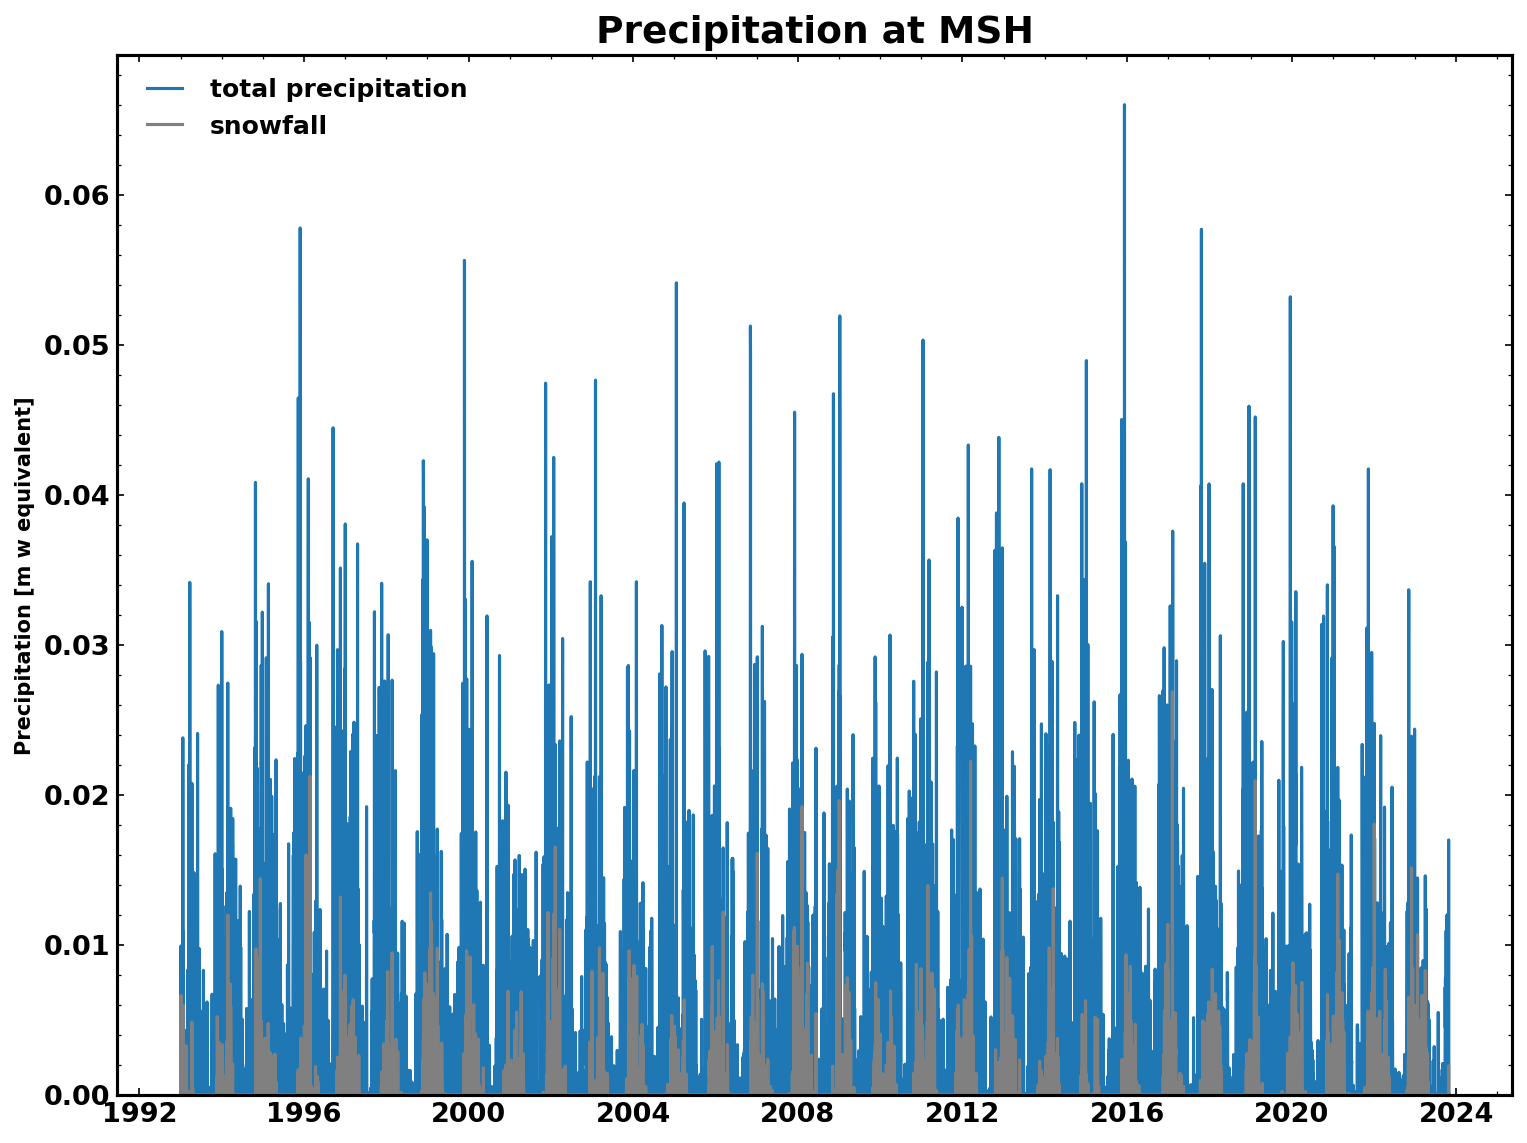

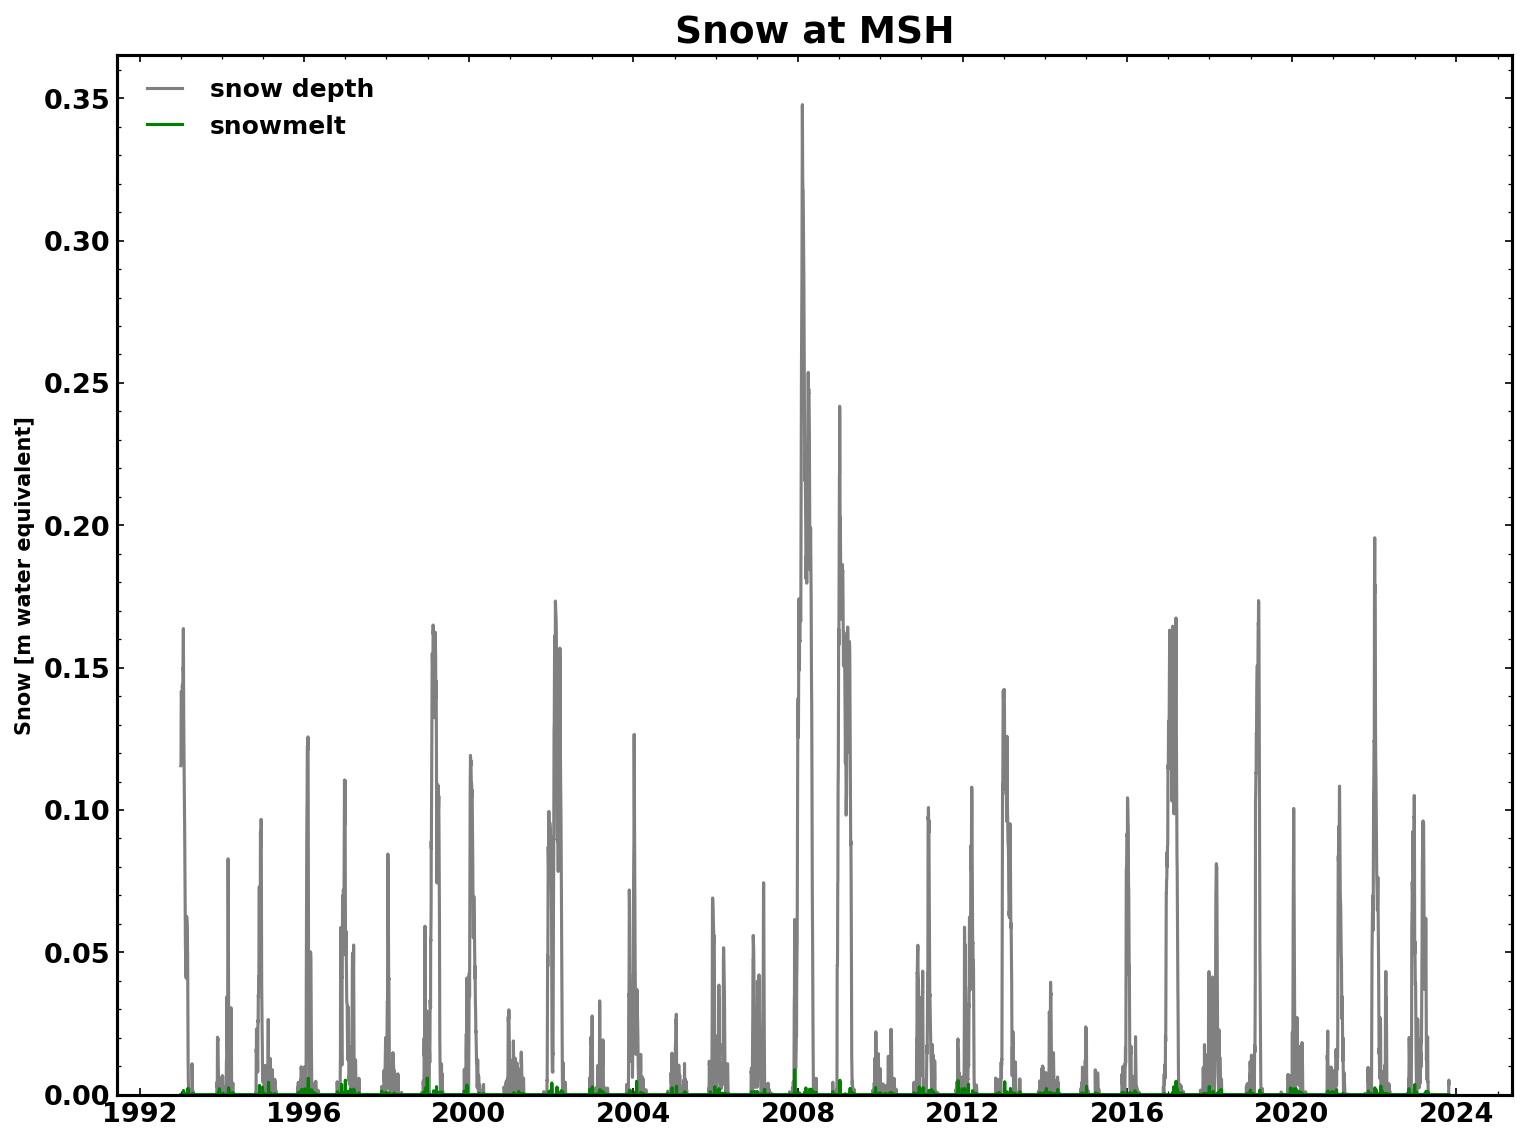

In [30]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 9))
plt.plot(t, precip[:, 0, 0], label='total precipitation')
plt.plot(t, snowfall[:, 0, 0], color='grey', label='snowfall')
plt.title('Precipitation at MSH')
plt.ylabel('Precipitation [m w equivalent]')
plt.ylim((0, None))
plt.legend()

plt.figure(figsize=(12, 9))
plt.title('Snowmelt at MSH')
plt.ylabel('Snow [m water equivalent]')
plt.plot(t, np.min(snowmelt, axis=(1,2)), color='green', label='snowmelt')
plt.ylim((0, None))
plt.legend()


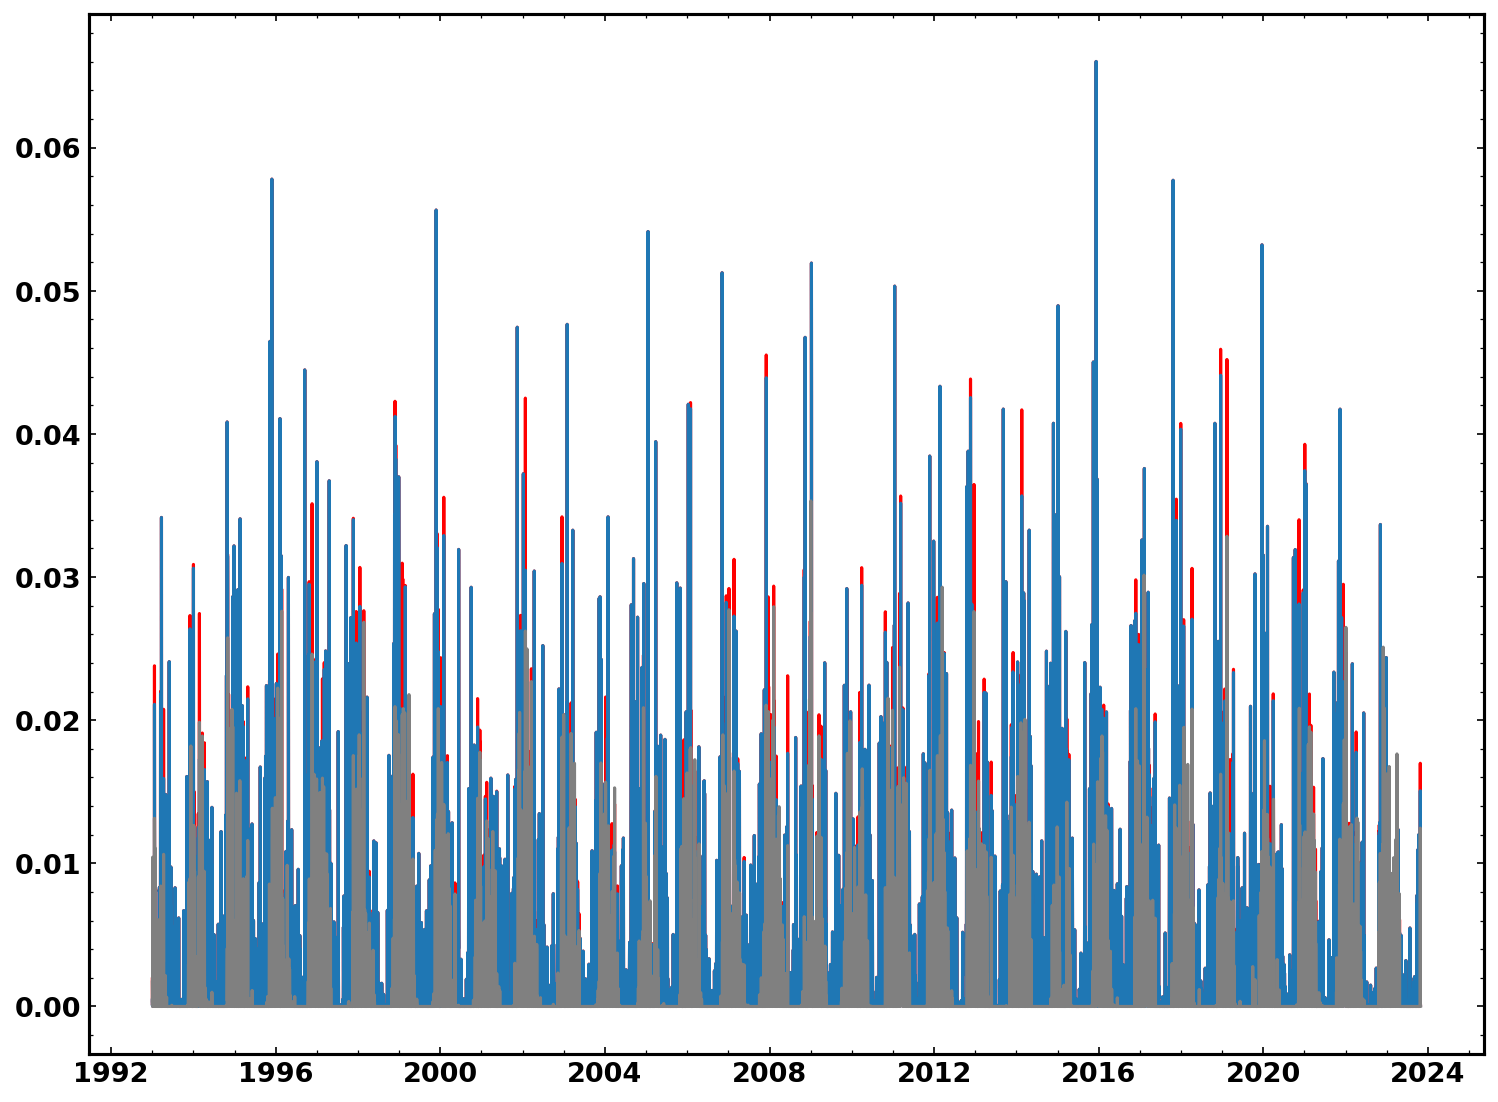

In [29]:
rain = precip - snowfall
plt.figure(figsize=(12, 9))

plt.plot(t, precip[:, 0, 0], color='r', label='total precipitation')
plt.plot(t, rain[:, 0, 0], label='rain')
plt.plot(t, np.max(snowfall, axis=(1,2)), color='grey', label='snowfall')


## compute water input rate

In [ ]:
water_supply_rate = precip - snowfall + snowmelt
# this can be used for further computations, you can for example save it as npz